c:/users/fungs/bmen501/Data/Val-hdf5/Image\TUM41-20190731.h5
c:/users/fungs/bmen501/Data/Val-hdf5/Mask\TUM41-20190731_robex.h5


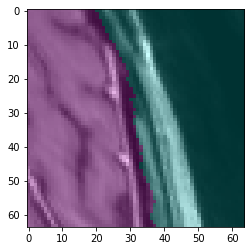

0.0 0.8091756714764874
1.0


In [12]:
#%matplotlib inline
import matplotlib.pylab as plt
import os
import glob
import numpy as np
import math
from data_augmentation_h5py import *
import cnn_utils
import natsort
import time
import random
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# -----------------------------------------------------
# IF SPLITTING BOTH HEALTHY AND UNHEALTHY BRAINS
# INTO TRAINING AND VALIDATION DIRECTORIES
# -----------------------------------------------------
# loading all the filenames
# h5py images
img_train = glob.glob("c:/users/fungs/bmen501/Data/Train-hdf5/Image/*.h5")
mask_train = glob.glob("c:/users/fungs/bmen501/Data/Train-hdf5/Mask/*.h5")
img_val = glob.glob("c:/users/fungs/bmen501/Data/Val-hdf5/Image/*.h5")
mask_val = glob.glob("c:/users/fungs/bmen501/Data/Val-hdf5/Mask/*.h5")
# -----------------------------------------------------

# sort the sets
img_train = natsort.natsorted(img_train)
mask_train = natsort.natsorted(mask_train)
img_val = natsort.natsorted(img_val)
mask_val = natsort.natsorted(mask_val)

print(img_val[-1])
print(mask_val[-1])

# training set data generator
train_dg = DataGeneratorH5PY2D(img_train, mask_train, (64,64), (30,30), 32,
                 rot = 30, shift_x = 15, shift_y = 10, augment_flag = True,
                 scale = 0.6, shear = 15, flip_x = True, flip_y = True, shuffle = True)

# validation set data generator
val_dg = DataGeneratorH5PY2D(img_val, mask_val, (64,64), (30,30), 32,
                  rot = 30, shift_x = 15, shift_y = 10, augment_flag = True,
                  scale = 0.6, shear = 15, flip_x = True, flip_y = True, shuffle = True)

X,Y = train_dg.__getitem__(100)
plt.figure()
plt.imshow(X[0,:,:,0], cmap = "gray")
plt.imshow(Y[0,:,:,0], cmap = "cool", alpha = 0.2)
plt.show()
print(X.min(),X.max())
print(Y.max())

Epoch 1/100
2479/2479 [==============================] - 315s 127ms/step - loss: -0.8198 - dice_coef: 0.8198 - val_loss: -0.8919 - val_dice_coef: 0.8919
Epoch 2/100
2479/2479 [==============================] - 315s 127ms/step - loss: -0.8770 - dice_coef: 0.8770 - val_loss: -0.9061 - val_dice_coef: 0.9061
Epoch 3/100
2479/2479 [==============================] - 316s 127ms/step - loss: -0.9010 - dice_coef: 0.9010 - val_loss: -0.9241 - val_dice_coef: 0.9241
Epoch 4/100
2479/2479 [==============================] - 314s 127ms/step - loss: -0.9148 - dice_coef: 0.9148 - val_loss: -0.9385 - val_dice_coef: 0.9385
Epoch 5/100
2479/2479 [==============================] - 314s 127ms/step - loss: -0.9226 - dice_coef: 0.9226 - val_loss: -0.9469 - val_dice_coef: 0.9469
Epoch 6/100
2479/2479 [==============================] - 313s 126ms/step - loss: -0.9263 - dice_coef: 0.9263 - val_loss: -0.9398 - val_dice_coef: 0.9398
Epoch 7/100
2479/2479 [==============================] - 314s 126ms/step - loss: -

2479/2479 [==============================] - 316s 127ms/step - loss: -0.9644 - dice_coef: 0.9644 - val_loss: -0.9694 - val_dice_coef: 0.9694
Epoch 53/100
2479/2479 [==============================] - 315s 127ms/step - loss: -0.9650 - dice_coef: 0.9650 - val_loss: -0.9716 - val_dice_coef: 0.9716
Epoch 54/100
2479/2479 [==============================] - 316s 128ms/step - loss: -0.9641 - dice_coef: 0.9641 - val_loss: -0.9675 - val_dice_coef: 0.9675
Epoch 55/100
2479/2479 [==============================] - 317s 128ms/step - loss: -0.9659 - dice_coef: 0.9659 - val_loss: -0.9707 - val_dice_coef: 0.9707
Epoch 56/100
2479/2479 [==============================] - 318s 128ms/step - loss: -0.9642 - dice_coef: 0.9642 - val_loss: -0.9716 - val_dice_coef: 0.9716
Epoch 57/100
2479/2479 [==============================] - 315s 127ms/step - loss: -0.9651 - dice_coef: 0.9651 - val_loss: -0.9717 - val_dice_coef: 0.9717
Epoch 58/100
2479/2479 [==============================] - 315s 127ms/step - loss: -0.9648

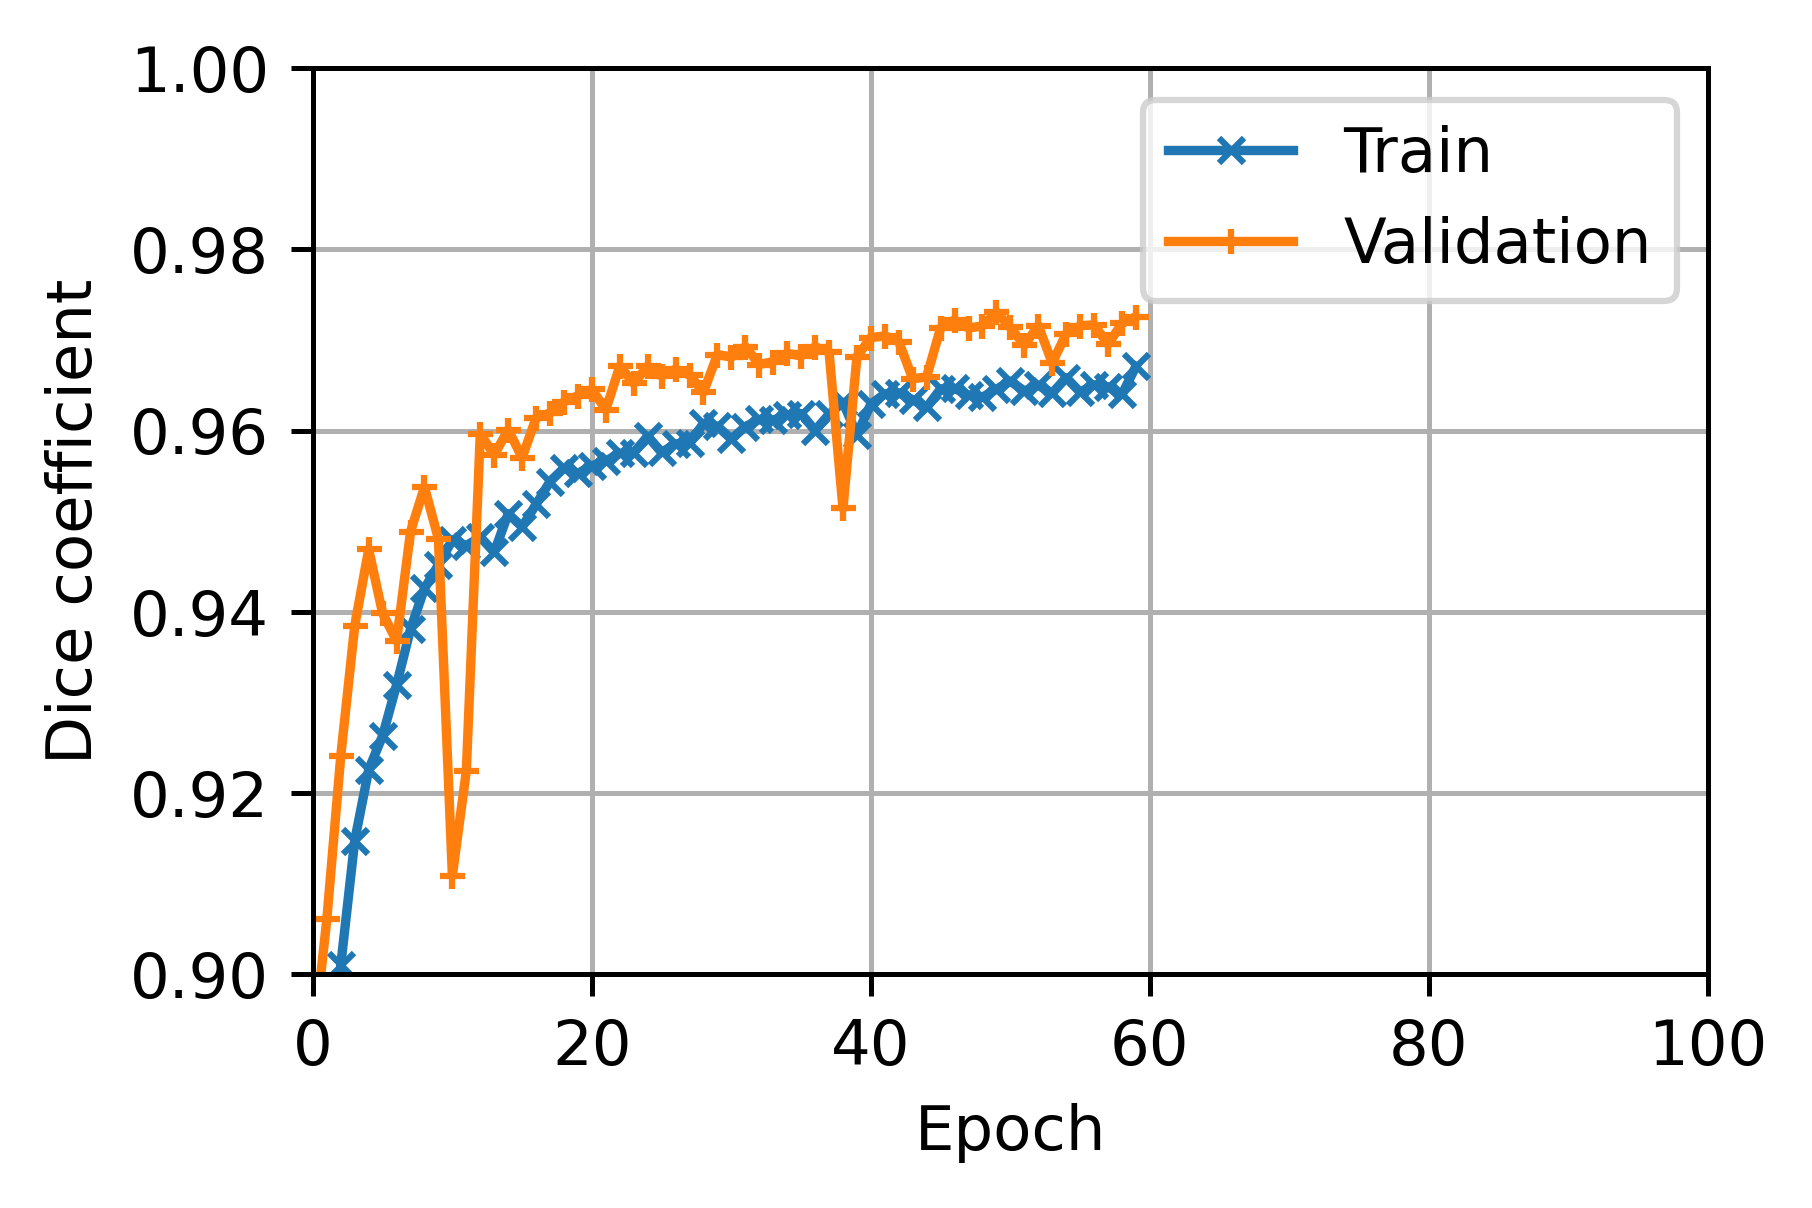

In [13]:
# string used to save models after each epoch
model_name = "c:/users/fungs/bmen501/Network/unet_data_best_aug_10pat_1204.hdf5"

# early stopping callback to shut down training after
# 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_dice_coef', patience=10, verbose=0, mode='max')

# checkpoint callback to save model  along the epochs
checkpoint = ModelCheckpoint(model_name, mode = 'max', monitor='val_dice_coef',verbose=0,
                             save_best_only=False, save_weights_only = True)
    
# create model
model = cnn_utils.get_unet_mod(patch_size = (64,64), nchannels = 1, learning_rate = 1e-4,
                                learning_decay = 5e-9)

hist = model.fit(train_dg, epochs=100, verbose = 1, validation_data = (val_dg),
                    callbacks = [checkpoint, earlyStopping], max_queue_size = 20, workers = 12)

# saving training history
np.save("c:/users/fungs/bmen501/network/dice_10pat_aug_1204.npy",np.array(hist.history['dice_coef']))
np.save("c:/users/fungs/bmen501/network/val_dice_10pat_aug_1204.npy",np.array(hist.history['val_dice_coef']))

# plotting the dice coefficient
dice = np.array(hist.history['dice_coef'])
val_dice = np.array(hist.history['val_dice_coef'])
loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
print (val_loss.argmin())
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(dice,'x-', markersize = 4,label = "Train")
plt.plot(val_dice,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlim(0,100)
plt.ylim(0.90,1.0)
plt.xlabel("Epoch")
plt.ylabel("Dice coefficient")
plt.show()